In [1]:
import numpy as np
import matplotlib.pyplot as plt

import numpyro
import numpyro.distributions as dist

from numpyro.infer import SA, NUTS, MCMC
import jax
from jax import random

import arviz as az

np.random.seed(394343)

/Users/yhra/miniconda3/envs/BATIP/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Centered vs. Non-centered in the Eight schools problem

The *eight schools problem* is a classic problem to illustrate hierarchical modeling. Read background material about this example on [this write-up](https://www.tensorflow.org/probability/examples/Eight_Schools) from the PPL *Tensorflow Probability*, then copy the implemetation of this example from the [numpyro documentation](https://num.pyro.ai/en/stable/getting_started.html?highlight=eight%20schools#a-simple-example-8-schools).

In [2]:
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

# Eight Schools example

def eight_schools(J, sigma, y=None):
    mu = numpyro.sample('mu', dist.Normal(0, 5))
    tau = numpyro.sample('tau', dist.HalfCauchy(5))
    with numpyro.plate('J', J):
        theta = numpyro.sample('theta', dist.Normal(mu, tau))
        numpyro.sample('obs', dist.Normal(theta, sigma), obs=y)

nuts_kernel = NUTS(eight_schools)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)

In [3]:
rng_key = random.PRNGKey(1056734)
mcmc.run(rng_key, J, sigma, y=y)
mcmc.print_summary()

sample: 100%|██████████| 1500/1500 [00:00<00:00, 2008.31it/s, 15 steps of size 1.11e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      4.59      3.04      4.50     -0.44      9.29    272.47      1.00
       tau      4.17      2.99      3.39      0.46      8.10     95.55      1.00
  theta[0]      6.63      5.77      6.04     -1.29     16.43    281.72      1.00
  theta[1]      5.16      4.70      4.99     -2.40     13.01    495.68      1.00
  theta[2]      3.96      5.48      4.34     -4.93     12.02    429.82      1.00
  theta[3]      5.03      4.84      4.96     -2.47     12.70    398.07      1.00
  theta[4]      3.74      4.54      3.88     -4.27     10.37    411.94      1.00
  theta[5]      4.32      4.69      4.35     -3.93     11.42    469.28      1.00
  theta[6]      6.87      4.77      6.31     -1.09     14.16    272.71      1.00
  theta[7]      5.27      5.20      5.13     -3.06     13.58    469.13      1.00

Number of divergences: 8


The summary tells us there are divergences. We can visualise where these divergent transitions occur as follows:

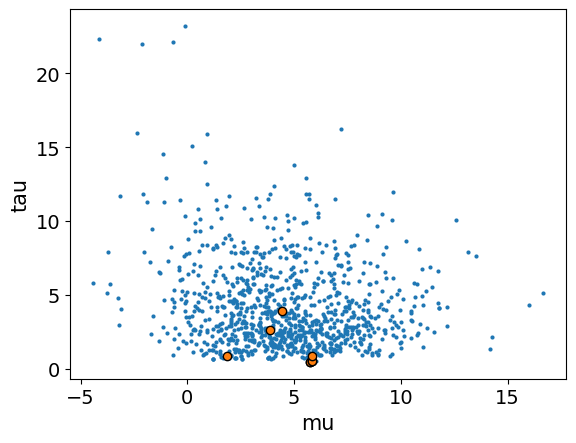

In [4]:
az_mcmc = az.from_numpyro(mcmc)
_ = az.plot_pair(az_mcmc, var_names=['mu', 'tau'], divergences=True)

We can try to alleviate these by increasing `target_accept_prob` and/or increasing the length of the warm-up stage using `num_warmup`:

In [5]:
nuts_kernel = NUTS(eight_schools, target_accept_prob=0.8)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
mcmc.run(rng_key, J, sigma, y=y)
mcmc.print_summary()

sample: 100%|██████████| 1500/1500 [00:00<00:00, 2378.46it/s, 15 steps of size 1.11e-01. acc. prob=0.94]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      4.59      3.04      4.50     -0.44      9.29    272.47      1.00
       tau      4.17      2.99      3.39      0.46      8.10     95.55      1.00
  theta[0]      6.63      5.77      6.04     -1.29     16.43    281.72      1.00
  theta[1]      5.16      4.70      4.99     -2.40     13.01    495.68      1.00
  theta[2]      3.96      5.48      4.34     -4.93     12.02    429.82      1.00
  theta[3]      5.03      4.84      4.96     -2.47     12.70    398.07      1.00
  theta[4]      3.74      4.54      3.88     -4.27     10.37    411.94      1.00
  theta[5]      4.32      4.69      4.35     -3.93     11.42    469.28      1.00
  theta[6]      6.87      4.77      6.31     -1.09     14.16    272.71      1.00
  theta[7]      5.27      5.20      5.13     -3.06     13.58    469.13      1.00

Number of divergences: 8


That didn't work - we still have degeneracies. Let's try the non-centered parameterisation instead:

In [6]:
def eight_schools_noncentered(J, sigma, y=None):
    mu = numpyro.sample('mu', dist.Normal(0, 5))
    tau = numpyro.sample('tau', dist.HalfCauchy(5))
    with numpyro.plate('J', J):
        eta = numpyro.sample('eta', dist.Normal(0, 1))
        theta = mu + tau * eta        
        numpyro.sample('obs', dist.Normal(theta, sigma), obs=y)

nuts_kernel_noncentered = NUTS(eight_schools_noncentered)
mcmc_noncentered = MCMC(nuts_kernel_noncentered, num_warmup=500, num_samples=1000)

In [7]:
_, rng_key = jax.random.split(rng_key)
mcmc_noncentered.run(rng_key, J, sigma, y=y)
mcmc_noncentered.print_summary()

sample: 100%|██████████| 1500/1500 [00:00<00:00, 2420.09it/s, 15 steps of size 3.32e-01. acc. prob=0.95]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    eta[0]      0.34      0.96      0.36     -1.40      1.84   1548.81      1.00
    eta[1]      0.12      0.96      0.15     -1.39      1.72   1559.97      1.00
    eta[2]     -0.08      0.95     -0.14     -1.70      1.35   1482.71      1.00
    eta[3]      0.04      0.96      0.07     -1.50      1.63   1651.73      1.00
    eta[4]     -0.19      0.92     -0.21     -1.67      1.27   1150.07      1.00
    eta[5]     -0.05      0.97     -0.04     -1.66      1.47   1548.27      1.00
    eta[6]      0.37      1.04      0.36     -1.32      2.03   1285.54      1.00
    eta[7]      0.08      0.99      0.09     -1.69      1.57   1461.13      1.00
        mu      4.22      3.42      4.23     -1.22     10.05   1256.92      1.00
       tau      3.66      3.25      2.77      0.00      7.89    660.48      1.00

Number of divergences: 0


The divergences have dissapeared!

Let's compare the two sets of samples from the centered vs. non-centered parameterisation of the model:

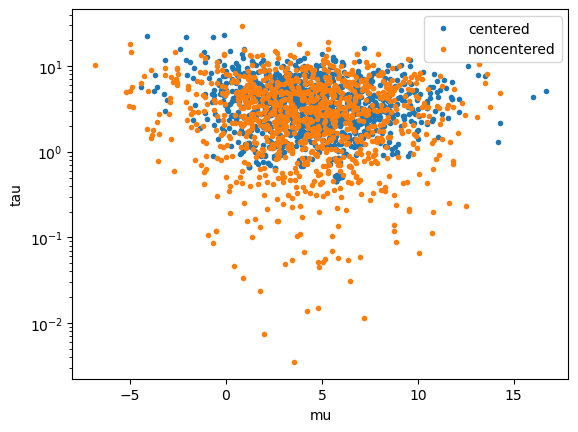

In [8]:
smp = mcmc.get_samples()
smp_noncentered = mcmc_noncentered.get_samples()

plt.semilogy(smp['mu'], smp['tau'], '.', label='centered')
plt.semilogy(smp_noncentered['mu'], smp_noncentered['tau'], '.', color='C1', label='noncentered')

plt.gca().set_xlabel('mu')
plt.gca().set_ylabel('tau')
plt.legend()

Samples from the noncentered model reach deeper into the neck of the funnel. From the other point of view, the few degeneracies seen in the centered model did prevent the trajectories from exploring the full posterior.

Changing from centered to non-centered parameterisation is a common way to alleviate divergences in hierarchical models. So common, that there is a second way to implement this in `numpyro`:

In [9]:
from numpyro.infer.reparam import LocScaleReparam

def eight_schools_noncentered_v2(J, sigma, y=None):
    mu = numpyro.sample('mu', dist.Normal(0, 5))
    tau = numpyro.sample('tau', dist.HalfCauchy(5))
    with numpyro.plate('J', J):
        with numpyro.handlers.reparam(config={'theta': LocScaleReparam(centered=0.)}):
            theta = numpyro.sample('theta', dist.Normal(mu, tau))
        numpyro.sample('obs', dist.Normal(theta, sigma), obs=y)

nuts_kernel_noncentered_v2 = NUTS(eight_schools_noncentered_v2)
mcmc_noncentered_v2 = MCMC(nuts_kernel_noncentered_v2, num_warmup=500, num_samples=1000)

We have used the `numpyro.infer.reparam.LocScaleReparam` object with keyword `centered=0` inside the `numpyro.handlers.reparam` context manager.

Running the inference:

In [10]:
_, rng_key = jax.random.split(rng_key)
mcmc_noncentered_v2.run(rng_key, J, sigma, y=y)
mcmc_noncentered_v2.print_summary()

sample: 100%|██████████| 1500/1500 [00:00<00:00, 2556.19it/s, 7 steps of size 5.13e-01. acc. prob=0.87]



                         mean       std    median      5.0%     95.0%     n_eff     r_hat
                 mu      4.31      3.41      4.31     -1.24      9.77   1113.21      1.00
                tau      3.52      3.02      2.66      0.01      7.31    550.35      1.00
theta_decentered[0]      0.32      1.02      0.33     -1.19      2.18   1058.46      1.00
theta_decentered[1]      0.09      0.90      0.10     -1.48      1.44    948.34      1.00
theta_decentered[2]     -0.07      0.94     -0.09     -1.62      1.39   1185.77      1.00
theta_decentered[3]      0.07      0.99      0.09     -1.47      1.76   1308.87      1.00
theta_decentered[4]     -0.17      0.98     -0.18     -1.66      1.57   1073.25      1.00
theta_decentered[5]     -0.06      0.92     -0.09     -1.64      1.39   1094.75      1.00
theta_decentered[6]      0.39      0.94      0.42     -1.14      1.96   1352.17      1.00
theta_decentered[7]      0.15      1.03      0.16     -1.59      1.71   1477.71      1.00

Number o

we still have zero divergences.